# Generating a Stronger Predictive Model with Additional Pre-Processing and Regularization
My intial linear regression model in notebook 2 produced a regresion model with a root mean squared error of 30,093. However, as I will demonstrate in this notebook, through additional feature engineering and the application of additional modeling techniques, most importantly regularization, the model performance can be improved significantly.

Notably, in the original linear regression model, I selected a specific number of features for my model out of a desire to avoid building a high-variance model. A high-variance model would be evident if there is a significant divergence in how our model performs on training versus testing data.

Typically, if this was the case in a model we could do the following:
- Gather more data (but this may be time-consuming and or expensive)
- Drop features (or limit the number of features in the model).-
- Make our existing features less complex. For example, if there are interaction or higher order terms, we might want to remove these from the models. 
- If applicable, choose a simpler model.
- Or employ regularization techniques.

The last option, regularization, provides a simple but powerful tool for improving model performance, we can include more features while reducing the risk that we over-engineer our model. Regularization automatically avoids overfitting by adding a penalty to the model's loss function when fitting.

In ordinary least squares regression (OLS), a line of best fit is created by selecting $B$ coefficients that minimize the sum of squared errors (SSE).

Regularization avoids overfitting by adding a penalty to the loss function, which limits the size of the coefficients--ideally making feature coefficients based on signal in our data as opposed to "noise" or random fluctuations in the data that we would ideally ignore.
- If the coefficients are large because of noise, then our loss function will likely gently slope, allowing regularization to push the coefficients considerably toward zero.
- If the coefficients are large because they're supposed to be large, then our loss function will likely be steep and regularization will have little effect on the coefficients.

The most common regularization techniques are Ridge and Lasso, both of which will be employed below.

In [1]:
# first we need to import the libraries we will use
# importing relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
# and import the data we explored and cleaned as part of our EDA in the first notebook
# train and test data files are provided as separate csv files

train = pd.read_csv('datasets/train_cleaned.csv')
test = pd.read_csv('datasets/test_cleaned.csv')

As shown in our EDA, there are object columns that have potential explanatory power that we want to dummify. However, we want to ensure that we are not dummifying columns with too many null values so that this does not skew our model. Below I will create a filter so that we only dummify object columns that have observations for 90% of the rows.

In [3]:
## want object columns where at least 90% of the homes have data 
dum_filter = (train.dtypes == 'object') & (train.isnull().mean() < .1)

dummies_train = pd.get_dummies(train.loc[:, dum_filter], dummy_na=True)

Below we will now move to getting a features list. Based on the EDA we performed, there are some columns we will drop that clearly do not have a relationship to the sale price, like the unique identifier for a given observation.

In [4]:
cols_to_drop = [ 'id','pid', 'mo_sold','saleprice']


num_df = train.loc[:, (train.dtypes != 'object') & (train.isnull().mean() < .1)].drop(columns = cols_to_drop)

Now that we have converted our features to numeric from object columns we can set our features.

In [5]:
numeric_features = num_df.columns

One problem we might want to consider when modeling is that the relationships between our features and our target may not be linear. For example, homes of different sizes may or types may not exhibit a linear relationship to price, given other features. 

If a relationship is non-linear, but we still need to capture the relationship we can apply polynomial regression to capture the curved relationship. 

Below, we will fit sklearn's PolynomialFeatures on our X / features data to engineer two-way terms and keep our original features

#### Set our X and y variables for modeling

In [18]:
X = pd.concat([num_df, dummies_train], axis=1)
y = train['saleprice']


As referenced in the previous notebook where we built a linear regression model, there are features that are highly correlated with each other--such as in 'garage_cars' and 'garage_area' below. 

In our prior model, to capture the relationship between the two, we created an interaction term by multiplying these features together, which allows us to see what affect the combination of two features have on our label.

In [19]:
z = train[['garage_cars', 'garage_area']]
z.corr()

,garage_cars,garage_area
garage_cars,1.000000,0.897083
garage_area,0.897083,1.000000


However, this is a manual process--finding potential interactions and creating them can become very time consuming with so many features available in our model.

With the `PolynomialFeatures` library in `sklearn` we can transform our features more efficiently:

When we fit the polynomial featues library to our existing set of features, we will get the following:
1. our original feature
2. our original feature squared with itself
3. our feature multiplied by another feature

This process will repeat for all features. **NOTE**: You'll need to set `include_bias=False`.

Because we dummified our object columns above, we now have 328 features before we engage in any additional feature engineering, this can be confirmed with the code below.

In [21]:
len(X.columns)

328

Now we can instantiate our PolynomialFeatures object from sklearn and fit it to our features list and then pull our updated list of feature names 

In [22]:
# Instantiate our PolynomialFeatures object to create all two-way terms.
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# Fit and transform our X data.
X_poly = poly.fit_transform(X)

In [24]:
len(poly.get_feature_names(X.columns))

54284

In [30]:
poly.get_feature_names(X.columns)[2000:2025]

['year_built ms_zoning_RH',
 'year_built ms_zoning_RL',
 'year_built ms_zoning_RM',
 'year_built ms_zoning_nan',
 'year_built street_Grvl',
 'year_built street_Pave',
 'year_built street_nan',
 'year_built lot_shape_IR1',
 'year_built lot_shape_IR2',
 'year_built lot_shape_IR3',
 'year_built lot_shape_Reg',
 'year_built lot_shape_nan',
 'year_built land_contour_Bnk',
 'year_built land_contour_HLS',
 'year_built land_contour_Low',
 'year_built land_contour_Lvl',
 'year_built land_contour_nan',
 'year_built utilities_AllPub',
 'year_built utilities_NoSeWa',
 'year_built utilities_NoSewr',
 'year_built utilities_nan',
 'year_built lot_config_Corner',
 'year_built lot_config_CulDSac',
 'year_built lot_config_FR2',
 'year_built lot_config_FR3']

We now have more than 54,000 features potential features created, without having engaged in manually searching for potential relationships and generating interactions manually. As shown with the code above, we can look at a sample of our new feature names and see interactions are being created.

Of course, by having so many features, we are introducing the bias/variance tradeoff and are running the risk that our model will be overfit to the features. 
#### This is where regularization comes in!

In [40]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, random_state=42)

In [41]:
ridge = RidgeCV()

In [42]:
sc = StandardScaler()
X_train_sc = pd.DataFrame(sc.fit_transform(X_train), columns=X.columns)
X_holdout_sc = pd.DataFrame(sc.fit_transform(X_holdout), columns=X.columns)

In [43]:
y_train_transformed = np.log1p(y_train)
y_holdout_transformed = np.log1p(y_holdout)

In [46]:
# using cross_validation_score to evaluate model
cross_val_score(ridge, X_train_sc, y_train_transformed, cv=5).mean()

0.8891938641620751

In [47]:
cross_val_score(ridge, X_holdout_sc, y_holdout_transformed, cv=5).mean()

0.8287231763115892

In [48]:
# fitting model to the training data
ridge.fit(X_train_sc, y_train_transformed)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [49]:
# evaluating training scores
ridge.score(X_train_sc, y_train_transformed)

0.9465483237973781

In [50]:
# evaluating holdout scores
predictions_ridge = ridge.predict(X_holdout_sc)

In [51]:
predictions_ridge_clean = np.expm1(predictions_ridge)

In [52]:
r2_score(y_holdout, predictions_ridge_clean)

0.9238475783922271

In [53]:
residuals_ridge = y_holdout - predictions_ridge_clean

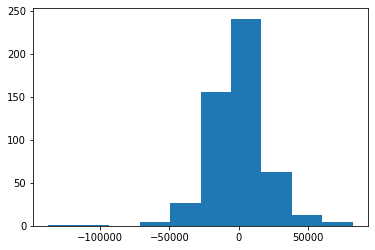

In [54]:
plt.hist(residuals_ridge);

In [55]:
np.sqrt(mean_squared_error(y_holdout, predictions_ridge_clean))

20455.55135564563

## Employing a Grid Search to Identify whether the optimal parameters for ridge regression!

In [56]:
from sklearn.model_selection import GridSearchCV
Ridge()

params = { 
    'alpha': [-20, -10,-1,1,10,20],
    'max_iter':[1e6]

}

gs = GridSearchCV(Ridge(), param_grid=params, cv=5)

In [57]:
gs.fit(X_train_sc, y_train_transformed)

/Users/nicolasavega/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [-20, -10, -1, 1, 10, 20],
                         'max_iter': [1000000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [58]:
gs.best_params_

{'alpha': 20, 'max_iter': 1000000.0}

In [59]:
gs.score(X_holdout_sc, y_holdout_transformed)

0.9053225428017657

In [60]:
X_sc = pd.DataFrame(sc.fit_transform(X), columns=X.columns)

In [61]:
y_transformed = np.log1p(y)

In [62]:
gs.fit(X_sc, y_transformed)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [-20, -10, -1, 1, 10, 20],
                         'max_iter': [1000000.0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [63]:
gs.best_estimator_.score(X_sc, y_transformed)

0.9422760279428587

In [64]:
# Based on best params above, re-run ridge with these new parameers
best_ridge = gs.best_estimator_ 

In [65]:
cross_val_score(best_ridge, X_sc, y_transformed, cv=5).mean()

0.9024210319180895

In [66]:
predictions_ridge_best = best_ridge.predict(X_sc)

In [67]:
predictions_ridge_best_clean = np.expm1(predictions_ridge_best)

In [68]:
r2_score(y, predictions_ridge_best_clean)

0.954468625280339

In [69]:
residuals_ridge_best = y - predictions_ridge_best_clean

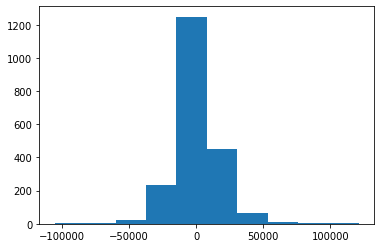

In [70]:
plt.hist(residuals_ridge_best);

In [71]:
np.sqrt(mean_squared_error(y, predictions_ridge_best_clean))

16913.22247615101